In [1]:
from dataloader import DiveFaceDataLoader
import keras
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import sys
import tensorflow as tf
import keras_vggface
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Lambda, Activation, ActivityRegularization
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, models, layers, regularizers
from keras.preprocessing import image
from keras_vggface import utils
from keras_vggface.vggface import VGGFace
from tensorflow.python.keras.backend import ndim

from PIL import Image
import tensorflow as tf
from tensorflow.compat.v1 import InteractiveSession


In [2]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)


In [3]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [4]:
#Preprocessing used for the images
def preprocess(img):
    img = np.expand_dims(img, axis=0)
    return img
# Prepare image
img_array = get_img_array('4K_120/HA4K_120/10011748@N08_identity_0/867465917_0.jpg', size=(224,224))


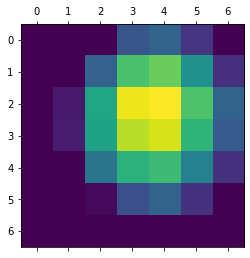

In [5]:
my_model = 'resnet50'
resnet = VGGFace(model = my_model)

#Select the last leayer as feature embedding  
last_layer = resnet.get_layer('avg_pool').output
feature_layer = Flatten(name='flatten')(last_layer)
model_vgg=Model(resnet.input, feature_layer)

#Freeze the model
model_vgg.trainable = False

model_class = keras.Sequential([
    model_vgg,
    keras.layers.Dense(3000,activation="relu"),
    keras.layers.Dense(2,activation="softmax")]
)
# Make model
classifier = 'Asian.h5'
model_class.load_weights(classifier)

vgg =  model_class.layers[0]
#vgg.summary()
ld = model_class.layers[-2](model_vgg.output)
classifier = model_class.layers[-1](ld)

model = Model(inputs=model_vgg.input,outputs=classifier)


#model.summary()
# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array,model, 'conv5_3_1x1_increase/bn')

# Display heatmap
plt.matshow(heatmap)
plt.show()


In [17]:
print("Clasificador:",classifier_name )
#hombre asiatico
img_path = '4K_120/HA4K_120/10056630@N08_identity_2/9676804769_0.jpg'
img_array = get_img_array(img_path, size=(224,224))
# Print what the top predicted class is
preds = model.predict(img_array)
if preds[0][0] > preds [0][1]:
    print("Prediccion: Hombre")
else:
    print("Prediccion: Mujer")
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array,model, 'conv5_3_1x1_increase/bn')
save_and_display_gradcam(img_path, heatmap)

NameError: name 'classifier_name' is not defined

In [18]:
#Preprocessing used for the images
def preprocess(img):
    img = np.expand_dims(img, axis=0)
    return img
# Prepare image
img_array = get_img_array('4K_120/HA4K_120/10011748@N08_identity_0/867465917_0.jpg', size=(224,224))


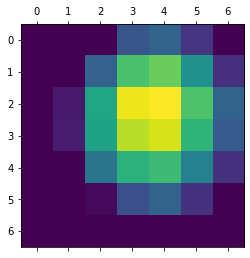

In [19]:
my_model = 'resnet50'
resnet = VGGFace(model = my_model)

#Select the last leayer as feature embedding  
last_layer = resnet.get_layer('avg_pool').output
feature_layer = Flatten(name='flatten')(last_layer)
model_vgg=Model(resnet.input, feature_layer)

#Freeze the model
model_vgg.trainable = False

model_class = keras.Sequential([
    model_vgg,
    keras.layers.Dense(3000,activation="relu"),
    keras.layers.Dense(2,activation="softmax")]
)
# Make model
classifier_name = 'Asian.h5'
model_class.load_weights(classifier_name)

vgg =  model_class.layers[0]
#vgg.summary()
ld = model_class.layers[-2](model_vgg.output)
classifier = model_class.layers[-1](ld)

model = Model(inputs=model_vgg.input,outputs=classifier)


#model.summary()
# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array,model, 'conv5_3_1x1_increase/bn')

# Display heatmap
plt.matshow(heatmap)
plt.show()


Clasificador: Asian.h5
Prediccion: Hombre


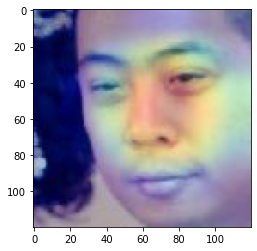

In [20]:
print("Clasificador:",classifier_name )
#hombre asiatico
img_path = '4K_120/HA4K_120/10056630@N08_identity_2/9676804769_0.jpg'
img_array = get_img_array(img_path, size=(224,224))
# Print what the top predicted class is
preds = model.predict(img_array)
if preds[0][0] > preds [0][1]:
    print("Prediccion: Hombre")
else:
    print("Prediccion: Mujer")
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array,model, 'conv5_3_1x1_increase/bn')
save_and_display_gradcam(img_path, heatmap)

Prediccion: Mujer


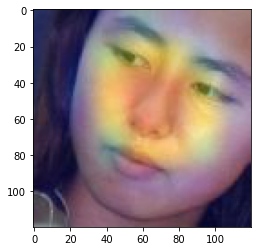

In [21]:

#mujer asiatica
img_path = '4K_120/MA4K_120/111882767@N08_identity_6/11437326484_1.jpg'
img_array = get_img_array(img_path, size=(224,224))
# Print what the top predicted class is
preds = model.predict(img_array)
if preds[0][0] > preds [0][1]:
    print("Prediccion: Hombre")
else:
    print("Prediccion: Mujer")
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array,model, 'conv5_3_1x1_increase/bn')
save_and_display_gradcam(img_path, heatmap)


Prediccion: Hombre


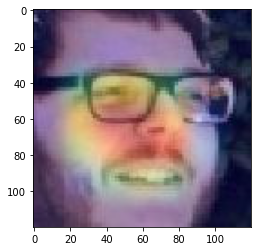

In [22]:
#hombre blanco
img_path = '4K_120/HB4K_120/10012300@N04_identity_2/8081040330_0.jpg'
img_array = get_img_array(img_path, size=(224,224))
# Print what the top predicted class is
preds = model.predict(img_array)
if preds[0][0] > preds [0][1]:
    print("Prediccion: Hombre")
else:
    print("Prediccion: Mujer")
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array,model, 'conv5_3_1x1_increase/bn')
save_and_display_gradcam(img_path, heatmap)

Prediccion: Mujer


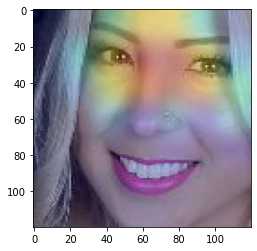

In [23]:

#mujer blanca
img_path = '4K_120/MB4K_120/101003966@N02_identity_49/10383421963_1.jpg'
img_array = get_img_array(img_path, size=(224,224))
# Print what the top predicted class is
preds = model.predict(img_array)
if preds[0][0] > preds [0][1]:
    print("Prediccion: Hombre")
else:
    print("Prediccion: Mujer")
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array,model, 'conv5_3_1x1_increase/bn')
save_and_display_gradcam(img_path, heatmap)



Prediccion: Hombre


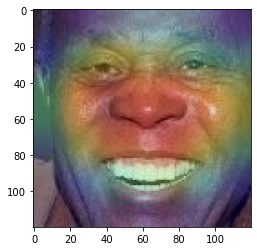

In [25]:
#hombre negro
img_path = '4K_120/HN4K_120/10022684@N08_identity_0/1258764222_0.jpg'
img_array = get_img_array(img_path, size=(224,224))
# Print what the top predicted class is
preds = model.predict(img_array)
if preds[0][0] > preds [0][1]:
    print("Prediccion: Hombre")
else:
    print("Prediccion: Mujer")
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array,model, 'conv5_3_1x1_increase/bn')
save_and_display_gradcam(img_path, heatmap)

Prediccion: Mujer


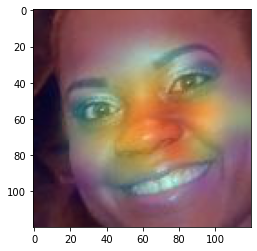

In [26]:

#mujer negra
img_path = '4K_120/MN4K_120/115558844@N05_identity_10/12179471673_6.jpg'
img_array = get_img_array(img_path, size=(224,224))
# Print what the top predicted class is
preds = model.predict(img_array)
if preds[0][0] > preds [0][1]:
    print("Prediccion: Hombre")
else:
    print("Prediccion: Mujer")
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array,model, 'conv5_3_1x1_increase/bn')
save_and_display_gradcam(img_path, heatmap)

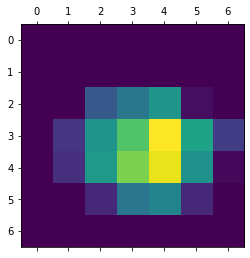

In [27]:
my_model = 'resnet50'
resnet = VGGFace(model = my_model)

#Select the last leayer as feature embedding  
last_layer = resnet.get_layer('avg_pool').output
feature_layer = Flatten(name='flatten')(last_layer)
model_vgg=Model(resnet.input, feature_layer)

#Freeze the model
model_vgg.trainable = False

model_class = keras.Sequential([
    model_vgg,
    keras.layers.Dense(3000,activation="relu"),
    keras.layers.Dense(2,activation="softmax")]
)
# Make model
classifier_name = 'White.h5'
model_class.load_weights(classifier_name)

vgg =  model_class.layers[0]
#vgg.summary()
ld = model_class.layers[-2](model_vgg.output)
classifier = model_class.layers[-1](ld)

model = Model(inputs=model_vgg.input,outputs=classifier)


#model.summary()
# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array,model, 'conv5_3_1x1_increase/bn')

# Display heatmap
plt.matshow(heatmap)
plt.show()


Clasificador: White.h5
Prediccion: Mujer


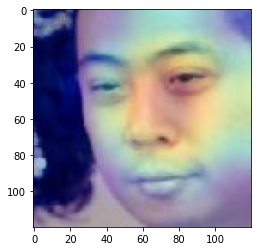

In [28]:
print("Clasificador:",classifier_name )
#hombre asiatico
img_path = '4K_120/HA4K_120/10056630@N08_identity_2/9676804769_0.jpg'
img_array = get_img_array(img_path, size=(224,224))
# Print what the top predicted class is
preds = model.predict(img_array)
if preds[0][0] > preds [0][1]:
    print("Prediccion: Hombre")
else:
    print("Prediccion: Mujer")
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array,model, 'conv5_3_1x1_increase/bn')
save_and_display_gradcam(img_path, heatmap)

Prediccion: Mujer


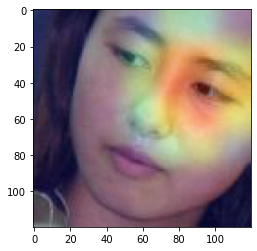

In [29]:

#mujer asiatica
img_path = '4K_120/MA4K_120/111882767@N08_identity_6/11437326484_1.jpg'
img_array = get_img_array(img_path, size=(224,224))
# Print what the top predicted class is
preds = model.predict(img_array)
if preds[0][0] > preds [0][1]:
    print("Prediccion: Hombre")
else:
    print("Prediccion: Mujer")
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array,model, 'conv5_3_1x1_increase/bn')
save_and_display_gradcam(img_path, heatmap)


Prediccion: Hombre


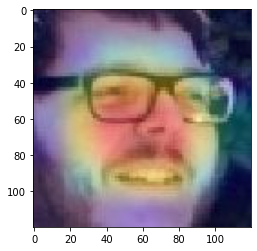

In [30]:
#hombre blanco
img_path = '4K_120/HB4K_120/10012300@N04_identity_2/8081040330_0.jpg'
img_array = get_img_array(img_path, size=(224,224))
# Print what the top predicted class is
preds = model.predict(img_array)
if preds[0][0] > preds [0][1]:
    print("Prediccion: Hombre")
else:
    print("Prediccion: Mujer")
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array,model, 'conv5_3_1x1_increase/bn')
save_and_display_gradcam(img_path, heatmap)

Prediccion: Mujer


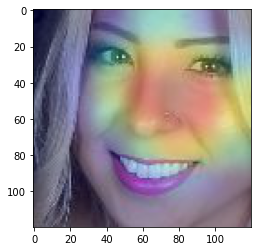

In [31]:

#mujer blanca
img_path = '4K_120/MB4K_120/101003966@N02_identity_49/10383421963_1.jpg'
img_array = get_img_array(img_path, size=(224,224))
# Print what the top predicted class is
preds = model.predict(img_array)
if preds[0][0] > preds [0][1]:
    print("Prediccion: Hombre")
else:
    print("Prediccion: Mujer")
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array,model, 'conv5_3_1x1_increase/bn')
save_and_display_gradcam(img_path, heatmap)



Prediccion: Hombre


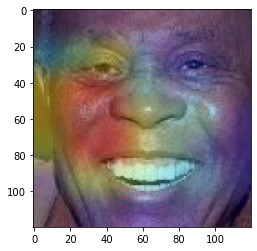

In [32]:
#hombre negro
img_path = '4K_120/HN4K_120/10022684@N08_identity_0/1258764222_0.jpg'
img_array = get_img_array(img_path, size=(224,224))
# Print what the top predicted class is
preds = model.predict(img_array)
if preds[0][0] > preds [0][1]:
    print("Prediccion: Hombre")
else:
    print("Prediccion: Mujer")
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array,model, 'conv5_3_1x1_increase/bn')
save_and_display_gradcam(img_path, heatmap)

Prediccion: Mujer


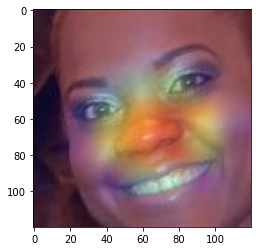

In [33]:

#mujer negra
img_path = '4K_120/MN4K_120/115558844@N05_identity_10/12179471673_6.jpg'
img_array = get_img_array(img_path, size=(224,224))
# Print what the top predicted class is
preds = model.predict(img_array)
if preds[0][0] > preds [0][1]:
    print("Prediccion: Hombre")
else:
    print("Prediccion: Mujer")
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array,model, 'conv5_3_1x1_increase/bn')
save_and_display_gradcam(img_path, heatmap)

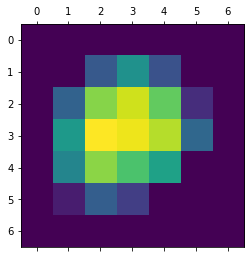

In [34]:
my_model = 'resnet50'
resnet = VGGFace(model = my_model)

#Select the last leayer as feature embedding  
last_layer = resnet.get_layer('avg_pool').output
feature_layer = Flatten(name='flatten')(last_layer)
model_vgg=Model(resnet.input, feature_layer)

#Freeze the model
model_vgg.trainable = False

model_class = keras.Sequential([
    model_vgg,
    keras.layers.Dense(3000,activation="relu"),
    keras.layers.Dense(2,activation="softmax")]
)
# Make model
classifier_name = 'Black.h5'
model_class.load_weights(classifier_name)

vgg =  model_class.layers[0]
#vgg.summary()
ld = model_class.layers[-2](model_vgg.output)
classifier = model_class.layers[-1](ld)

model = Model(inputs=model_vgg.input,outputs=classifier)


#model.summary()
# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array,model, 'conv5_3_1x1_increase/bn')

# Display heatmap
plt.matshow(heatmap)
plt.show()


Clasificador: Black.h5
Prediccion: Hombre


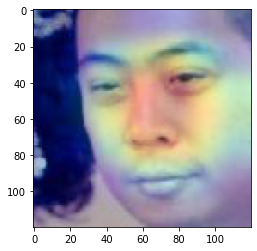

In [35]:
print("Clasificador:",classifier_name )
#hombre asiatico
img_path = '4K_120/HA4K_120/10056630@N08_identity_2/9676804769_0.jpg'
img_array = get_img_array(img_path, size=(224,224))
# Print what the top predicted class is
preds = model.predict(img_array)
if preds[0][0] > preds [0][1]:
    print("Prediccion: Hombre")
else:
    print("Prediccion: Mujer")
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array,model, 'conv5_3_1x1_increase/bn')
save_and_display_gradcam(img_path, heatmap)

Prediccion: Mujer


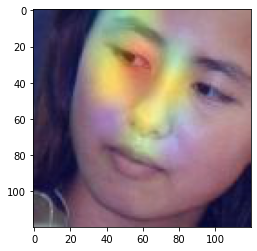

In [36]:

#mujer asiatica
img_path = '4K_120/MA4K_120/111882767@N08_identity_6/11437326484_1.jpg'
img_array = get_img_array(img_path, size=(224,224))
# Print what the top predicted class is
preds = model.predict(img_array)
if preds[0][0] > preds [0][1]:
    print("Prediccion: Hombre")
else:
    print("Prediccion: Mujer")
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array,model, 'conv5_3_1x1_increase/bn')
save_and_display_gradcam(img_path, heatmap)


Prediccion: Hombre


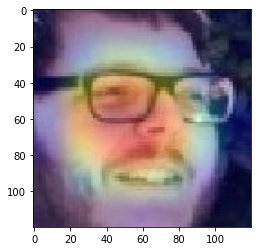

In [37]:
#hombre blanco
img_path = '4K_120/HB4K_120/10012300@N04_identity_2/8081040330_0.jpg'
img_array = get_img_array(img_path, size=(224,224))
# Print what the top predicted class is
preds = model.predict(img_array)
if preds[0][0] > preds [0][1]:
    print("Prediccion: Hombre")
else:
    print("Prediccion: Mujer")
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array,model, 'conv5_3_1x1_increase/bn')
save_and_display_gradcam(img_path, heatmap)

Prediccion: Mujer


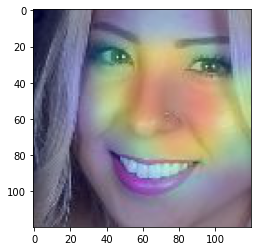

In [38]:

#mujer blanca
img_path = '4K_120/MB4K_120/101003966@N02_identity_49/10383421963_1.jpg'
img_array = get_img_array(img_path, size=(224,224))
# Print what the top predicted class is
preds = model.predict(img_array)
if preds[0][0] > preds [0][1]:
    print("Prediccion: Hombre")
else:
    print("Prediccion: Mujer")
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array,model, 'conv5_3_1x1_increase/bn')
save_and_display_gradcam(img_path, heatmap)



Prediccion: Hombre


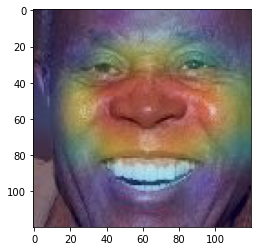

In [39]:
#hombre negro
img_path = '4K_120/HN4K_120/10022684@N08_identity_0/1258764222_0.jpg'
img_array = get_img_array(img_path, size=(224,224))
# Print what the top predicted class is
preds = model.predict(img_array)
if preds[0][0] > preds [0][1]:
    print("Prediccion: Hombre")
else:
    print("Prediccion: Mujer")
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array,model, 'conv5_3_1x1_increase/bn')
save_and_display_gradcam(img_path, heatmap)

Prediccion: Mujer


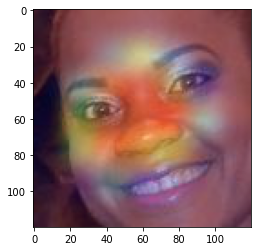

In [40]:

#mujer negra
img_path = '4K_120/MN4K_120/115558844@N05_identity_10/12179471673_6.jpg'
img_array = get_img_array(img_path, size=(224,224))
# Print what the top predicted class is
preds = model.predict(img_array)
if preds[0][0] > preds [0][1]:
    print("Prediccion: Hombre")
else:
    print("Prediccion: Mujer")
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array,model, 'conv5_3_1x1_increase/bn')
save_and_display_gradcam(img_path, heatmap)

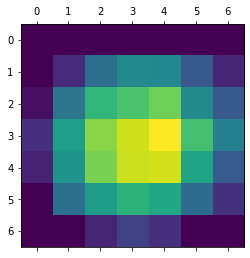

In [41]:
my_model = 'resnet50'
resnet = VGGFace(model = my_model)

#Select the last leayer as feature embedding  
last_layer = resnet.get_layer('avg_pool').output
feature_layer = Flatten(name='flatten')(last_layer)
model_vgg=Model(resnet.input, feature_layer)

#Freeze the model
model_vgg.trainable = False

model_class = keras.Sequential([
    model_vgg,
    keras.layers.Dense(3000,activation="relu"),
    keras.layers.Dense(2,activation="softmax")]
)
# Make model
classifier_name = 'Balanced.h5'
model_class.load_weights(classifier_name)

vgg =  model_class.layers[0]
#vgg.summary()
ld = model_class.layers[-2](model_vgg.output)
classifier = model_class.layers[-1](ld)

model = Model(inputs=model_vgg.input,outputs=classifier)


#model.summary()
# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array,model, 'conv5_3_1x1_increase/bn')

# Display heatmap
plt.matshow(heatmap)
plt.show()


Clasificador: Balanced.h5
Prediccion: Hombre


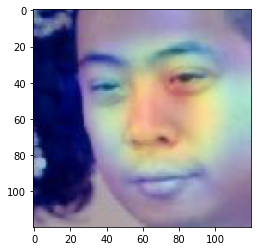

In [42]:
print("Clasificador:",classifier_name )
#hombre asiatico
img_path = '4K_120/HA4K_120/10056630@N08_identity_2/9676804769_0.jpg'
img_array = get_img_array(img_path, size=(224,224))
# Print what the top predicted class is
preds = model.predict(img_array)
if preds[0][0] > preds [0][1]:
    print("Prediccion: Hombre")
else:
    print("Prediccion: Mujer")
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array,model, 'conv5_3_1x1_increase/bn')
save_and_display_gradcam(img_path, heatmap)

Prediccion: Mujer


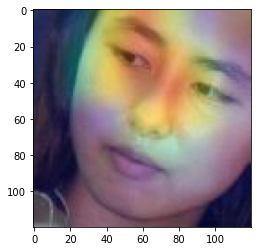

In [43]:

#mujer asiatica
img_path = '4K_120/MA4K_120/111882767@N08_identity_6/11437326484_1.jpg'
img_array = get_img_array(img_path, size=(224,224))
# Print what the top predicted class is
preds = model.predict(img_array)
if preds[0][0] > preds [0][1]:
    print("Prediccion: Hombre")
else:
    print("Prediccion: Mujer")
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array,model, 'conv5_3_1x1_increase/bn')
save_and_display_gradcam(img_path, heatmap)


Prediccion: Hombre


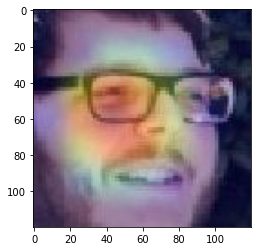

In [44]:
#hombre blanco
img_path = '4K_120/HB4K_120/10012300@N04_identity_2/8081040330_0.jpg'
img_array = get_img_array(img_path, size=(224,224))
# Print what the top predicted class is
preds = model.predict(img_array)
if preds[0][0] > preds [0][1]:
    print("Prediccion: Hombre")
else:
    print("Prediccion: Mujer")
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array,model, 'conv5_3_1x1_increase/bn')
save_and_display_gradcam(img_path, heatmap)

Prediccion: Mujer


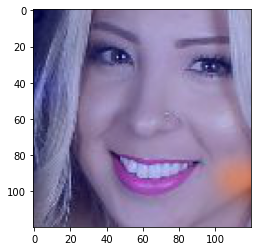

In [45]:

#mujer blanca
img_path = '4K_120/MB4K_120/101003966@N02_identity_49/10383421963_1.jpg'
img_array = get_img_array(img_path, size=(224,224))
# Print what the top predicted class is
preds = model.predict(img_array)
if preds[0][0] > preds [0][1]:
    print("Prediccion: Hombre")
else:
    print("Prediccion: Mujer")
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array,model, 'conv5_3_1x1_increase/bn')
save_and_display_gradcam(img_path, heatmap)



Prediccion: Mujer


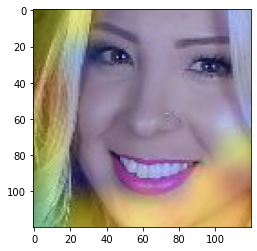

In [46]:

#mujer blanca
img_path = '4K_120/MB4K_120/101003966@N02_identity_49/10383421963_1.jpg'
img_array = get_img_array(img_path, size=(224,224))
# Print what the top predicted class is
preds = model.predict(img_array)
if preds[0][0] > preds [0][1]:
    print("Prediccion: Hombre")
else:
    print("Prediccion: Mujer")
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array,model, 'conv5_3_1x1_increase')
save_and_display_gradcam(img_path, heatmap)



Prediccion: Hombre


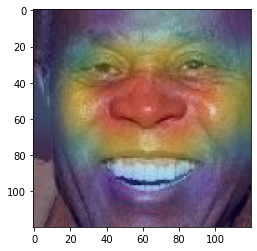

In [47]:
#hombre negro
img_path = '4K_120/HN4K_120/10022684@N08_identity_0/1258764222_0.jpg'
img_array = get_img_array(img_path, size=(224,224))
# Print what the top predicted class is
preds = model.predict(img_array)
if preds[0][0] > preds [0][1]:
    print("Prediccion: Hombre")
else:
    print("Prediccion: Mujer")
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array,model, 'conv5_3_1x1_increase/bn')
save_and_display_gradcam(img_path, heatmap)

Prediccion: Hombre


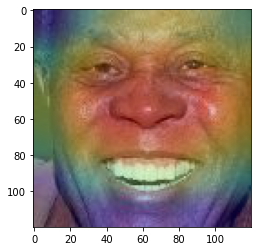

In [48]:
#hombre negro
img_path = '4K_120/HN4K_120/10022684@N08_identity_0/1258764222_0.jpg'
img_array = get_img_array(img_path, size=(224,224))
# Print what the top predicted class is
preds = model.predict(img_array)
if preds[0][0] > preds [0][1]:
    print("Prediccion: Hombre")
else:
    print("Prediccion: Mujer")
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array,model, 'conv5_3_1x1_increase')
save_and_display_gradcam(img_path, heatmap)

Prediccion: Mujer


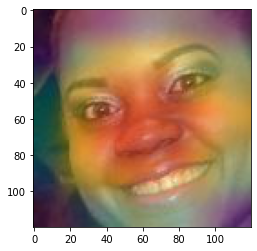

In [49]:

#mujer negra
img_path = '4K_120/MN4K_120/115558844@N05_identity_10/12179471673_6.jpg'
img_array = get_img_array(img_path, size=(224,224))
# Print what the top predicted class is
preds = model.predict(img_array)
if preds[0][0] > preds [0][1]:
    print("Prediccion: Hombre")
else:
    print("Prediccion: Mujer")
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array,model, 'conv5_3_1x1_increase')
save_and_display_gradcam(img_path, heatmap)

Prediccion: Hombre


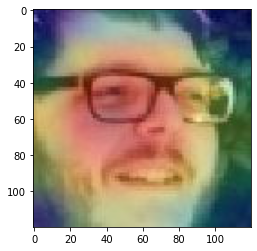

In [50]:
#hombre blanco
img_path = '4K_120/HB4K_120/10012300@N04_identity_2/8081040330_0.jpg'
img_array = get_img_array(img_path, size=(224,224))
# Print what the top predicted class is
preds = model.predict(img_array)
if preds[0][0] > preds [0][1]:
    print("Prediccion: Hombre")
else:
    print("Prediccion: Mujer")
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array,model, 'conv5_3_1x1_increase')
save_and_display_gradcam(img_path, heatmap)